# MovieLens and Recommender System

### System I: Recommendation Based on Genres

In [1]:
import numpy as np
import pandas as pd
import streamlit as st


In [2]:
import warnings
warnings.filterwarnings('ignore')

## Recommender System

Download the MovieLens 1M Dataset. You’ll find four files: README, movies.dat, ratings.dat, and users.dat. Check the readme file to understand the format of the other three files.

In [3]:
import pandas as pd
ratings = pd.read_csv('ratings.dat', sep='::', engine = 'python', header=None)
ratings.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
movies = pd.read_csv('movies.dat', sep='::', engine = 'python',
                     encoding="ISO-8859-1", header = None)
movies.columns = ['MovieID', 'Title', 'Genres']

Explore the relationship between movie ratings and movie genres. First, simplify movie genres: multiple genres to ‘Multiple’.

In [4]:
multiple_idx = pd.Series([("|" in movie) for movie in movies['Genres']])
movies.loc[multiple_idx, 'Genres'] = 'Multiple'

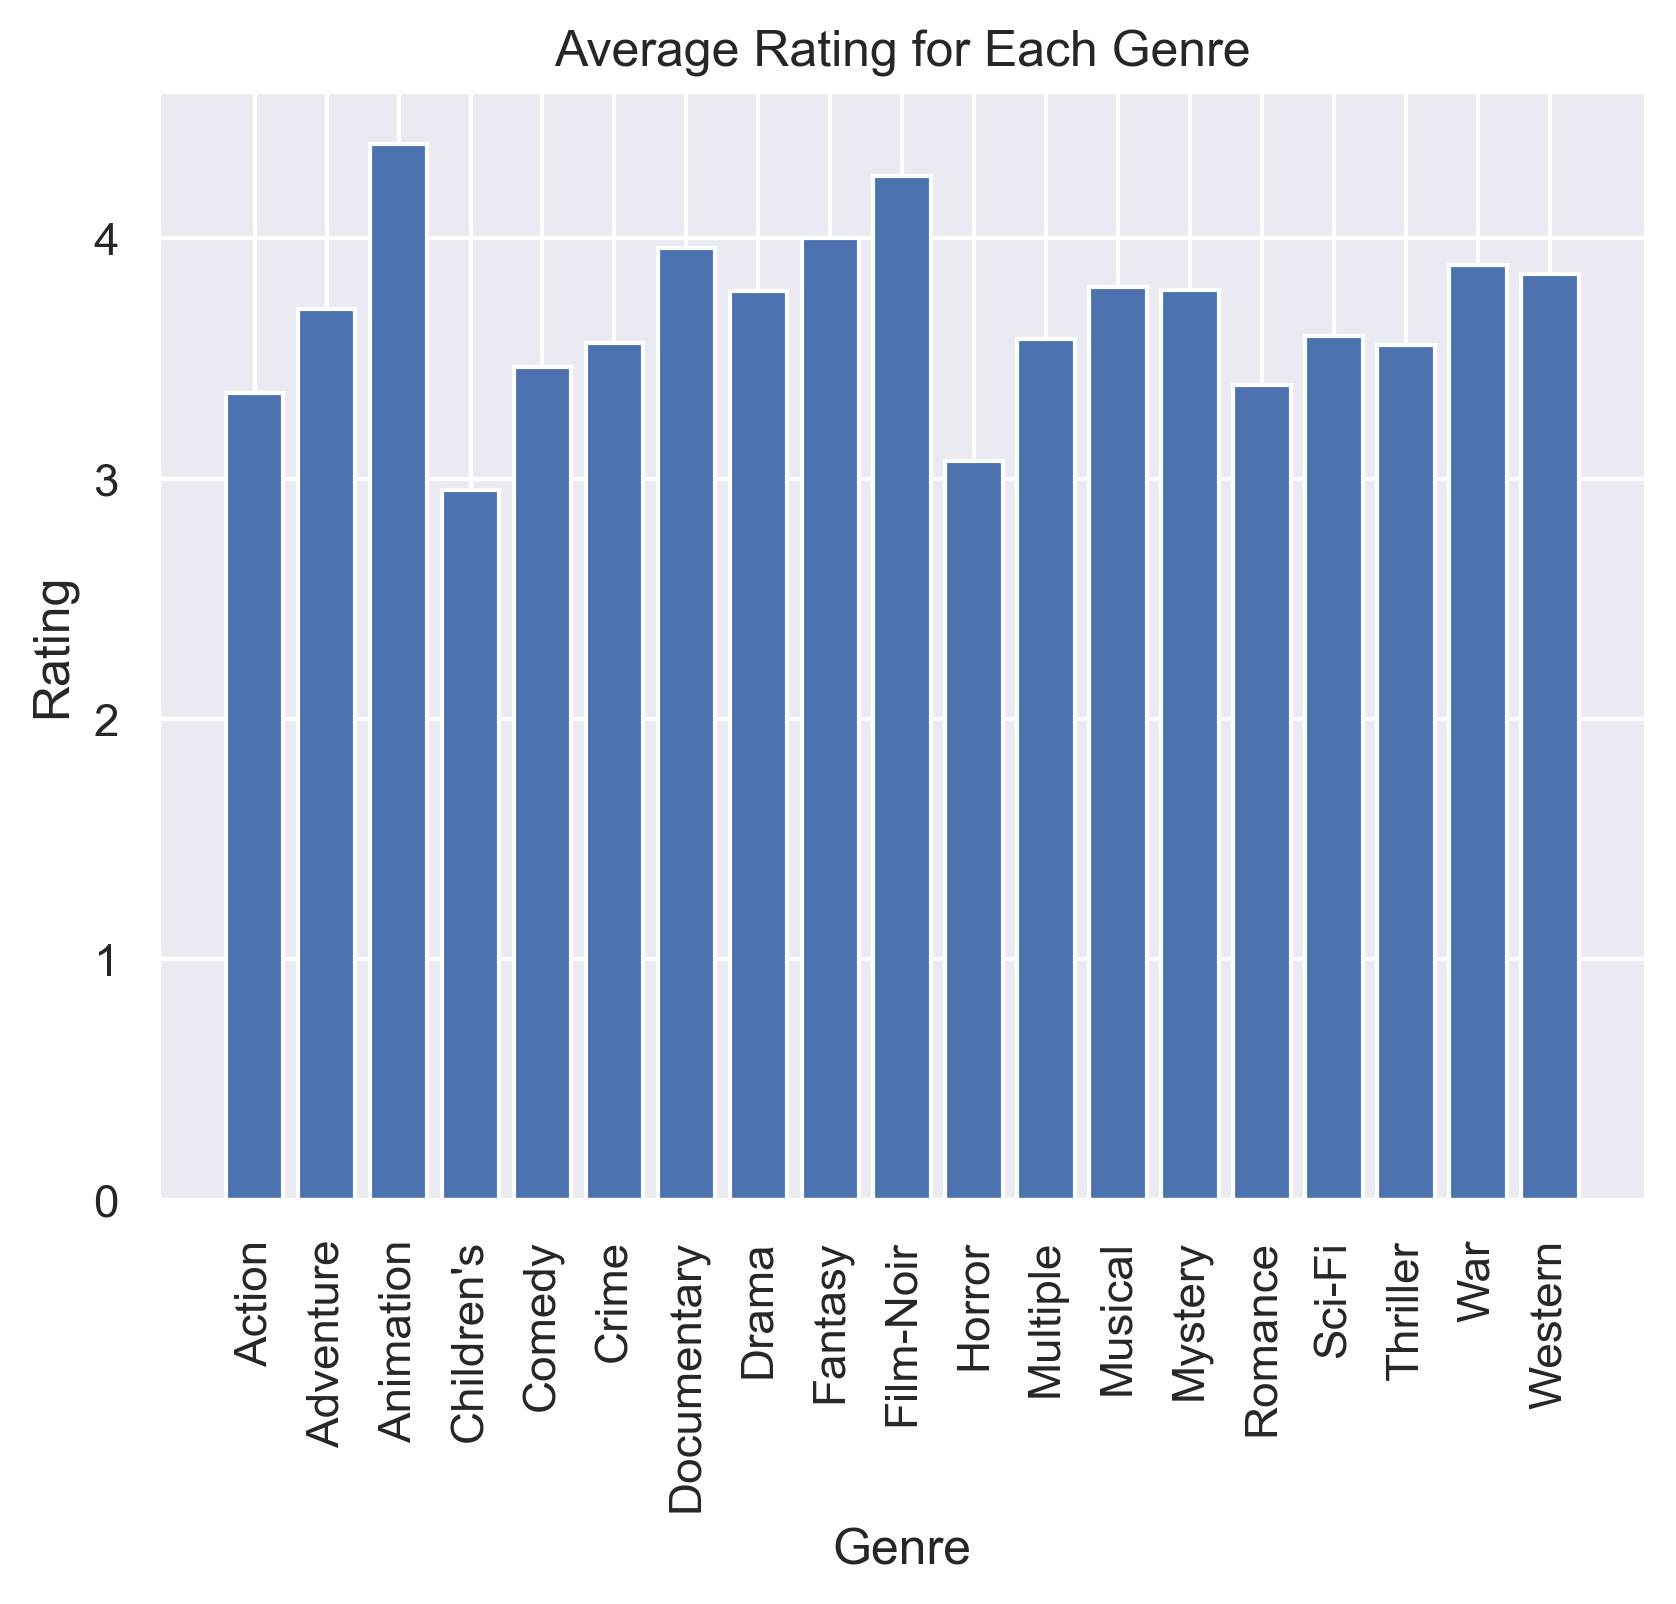

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 300
sns.set()

rating_merged = ratings.merge(movies, left_on = 'MovieID', right_on = 'MovieID')
mean_ratings = rating_merged[['Rating', 'Genres']].groupby('Genres').mean()
plt.bar(mean_ratings.index, mean_ratings['Rating']);
plt.xticks(rotation=90);
plt.title('Average Rating for Each Genre');
plt.xlabel('Genre');
plt.ylabel('Rating');

## Exploratory Data Analysis

We train a recommender system and make prediction on the test data. We will use the surprise library. First, we must create a dataset object. To do so, we start with a dataframe with columns itemID, userID and rating and use the load_from_df method.

In [6]:
from surprise import Dataset, Reader
ratings = ratings.drop('Timestamp', axis = 1)
ratings.columns = ['userID', 'itemID', 'rating']
ratings = ratings[['itemID', 'userID', 'rating']]
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[["userID", "itemID", "rating"]], reader)

Next, we will split the data into a train and test.

In [7]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size = 0.25)

We'll use the user-based collaborative filtering method with cosine similarity and normalization.

In [8]:
from surprise.prediction_algorithms.knns import KNNWithZScore
sim_options = {'name': 'cosine', 'user_based': True}
algo = KNNWithZScore(sim_options=sim_options).fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


Now let’s make prediction on the test data:

In [9]:
import numpy as np
preds = [algo.predict(uid, iid).est for uid, iid, _ in testset]
results_table = pd.DataFrame(np.stack([testset])[0], 
                             columns = ['itemID', 'userID', 'rating'])
results_table['predicted'] = preds
results_merged = results_table.merge(movies, 
                                     left_on = 'itemID', right_on = 'MovieID')
results_merged = results_merged.drop('itemID', axis = 1)
results_merged.sort_values('userID')

,userID,rating,predicted,MovieID,Title,Genres
51845,1.0,5.0,4.943314,577,Andre (1994),Multiple
87886,1.0,5.0,4.444397,3845,And God Created Woman (Et Dieu&#8230;Créa la F...,Drama
149887,1.0,5.0,4.375451,2817,Aces: Iron Eagle III (1992),Multiple
155064,1.0,5.0,4.699692,3344,Blood Feast (1963),Horror
155072,1.0,4.0,3.988558,2459,"Texas Chainsaw Massacre, The (1974)",Horror
...,...,...,...,...,...,...
43716,3952.0,3.0,3.601760,1472,City of Industry (1997),Multiple
79869,3952.0,4.0,3.934095,1546,Schizopolis (1996),Comedy
80162,3952.0,4.0,3.958286,960,Angel on My Shoulder (1946),Multiple
43903,3952.0,5.0,4.044709,2168,Dance with Me (1998),Multiple
